# Modelos clasificación de texto - RNN (Variante **LSTM-AWD**)


# 1.Preparación del entorno

## 1.1.Instalación y carga de librerías

Al finalizar la instalación de deberá reiniciar el kernel.

In [ ]:
!pip install fastai -Uqq
!pip install datasets -Uqq

Cargamos a continuación las librerías que necesitaremos en esta práctica que son la parte de procesado de lenguaje natural de la librería fastAI, la librería pandas, y la funcionalidad para cargar datasets de HuggingFace (**esta última podemos eliminarla porque no vamos a utilizarla. Trabajaremos el dataset directamente con pandas**).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fastai.text.all import *
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [ ]:
# Instalación de la ayuda de FastAI
!pip install nbdev

## 1.2.Definición de variables de configuración del proceso

In [ ]:
# Constante para la reproducción de resultados aleatorios
seed = 42
# Establecimiento del numero de épocas de entrenamiento (normalmente 10)
nEpochs = 15

# 2.Obtención y análisis del dataset

Para la carga del dataset se ha decidido proceder del modo siguiente:
* Habilitar en Google Drive un directorio para almacenar el dataset ya preprocesado
* Cargar los comandos para poder acceder desde el cuaderno a dicho directorio y cargar el dataset en tiempo de ejecución
* Realizar la carga del dataset que presenta 46.787 filas con varias características, de las que solo nos son de interés 2 (texto y nivel)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carga del dataset a un pandas
corpus = pd.read_csv('/content/drive/MyDrive/Datos/corpusELE.csv')

## 2.1.Análisis Exploratorio
Se realiza un estudio del contenido del dataset orientado al análisis posterior. Entre los aspectos de interés a considerar se estudia:
* Observación de los datos, tamaño dataset, características
* Verificación no existencia de nulos
* Número de clases existentes (target)
* Número de instancias de cada clase ¿balanceado?
* Longitud del texto y número de palabras para cada clase

In [ ]:
corpus.head(5)

,Unnamed: 0,numero,nivel,lenguaM,pClave,frase,archivo
0,0,1.0,A1,Árabe,",","mi familia es solo 3 persona , me madre y me hermano y mi .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
1,3,4.0,B2,Portugués,",","La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
2,6,7.0,A2,Inglés,",","Nos ibe muchas luegos como museos , restaurantes , y parques .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
3,7,8.0,A1,Árabe,",","Entoncés , se puede que llego tarde .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
4,9,10.0,A1,Portugués,",","A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"


In [ ]:
# Tamaño del dataset
corpus.shape

(46787, 7)

In [ ]:
# Verificamos que no hay ningún valor null en el dataset
corpus.isnull().sum()

In [ ]:
# Características del dataframe
corpus.axes

[RangeIndex(start=0, stop=46787, step=1),
 Index(['Unnamed: 0', 'numero', 'nivel', 'lenguaM', 'pClave', 'frase',
        'archivo'],
       dtype='object')]

In [ ]:
# Diferentes niveles
niveles = corpus['nivel'].unique()
niveles.sort()
niveles

array(['A1', 'A2', 'B1', 'B2', 'C1'], dtype=object)

De los resultados de las celdas anteriores podemos concluir que el dataset contiene 46787 filas con 7 características, que no tiene ningún valor nulo y que el detalle de las características es el siguiente:

* **numero**: Número de orden original de la frase en el conjunto de archivos
* **nivel**: Código del nivel de destreza en castellano de acuerdo al marco común europeo. Admite 5 valores posibles: A1, A2, B1, B2 y C1
* **lenguaM**: Lengua materna del estudiante. Campo categórico con los siguientes valores posibles: Chino Mandarín, Francés, Inglés, Portugués, Ruso y Árabe
* **pClave**: Palabra clave de la frase
* **archivo**: Nombre y ubicación del archivo inicial de datos


In [ ]:
# Cuenta de los registros por cada nivel
corpus["nivel"].value_counts()

A2    13926
A1    12284
B1    10848
B2     6601
C1     3128
Name: nivel, dtype: int64

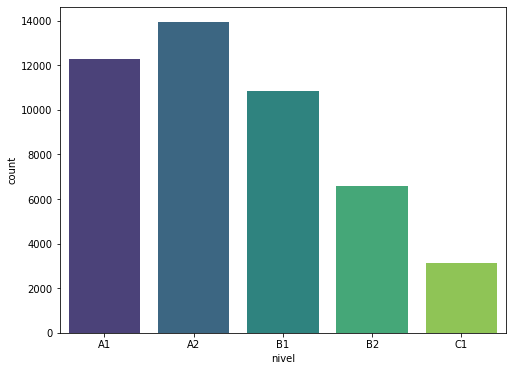

In [ ]:
# Gráfico de barras del número de registros por característica categorica
import seaborn as sb
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='nivel', data=corpus, orient='h', palette='viridis', order =['A1', 'A2', 'B1', 'B2', 'C1'])

## 2.2.Preparación del conjunto de datos
El objeto de esta sección es realizar los ajustes necesarios en el dataset para que pueda ser utilizado por las librerías de FastAI que imnplementan la LSTM. Entre los aspectos a considerar se encuentran:
* Eliminación de las columnas que no son de interés para el problema de clasificación
* Adecuación de las características del dataset.


### 2.2.1.Eliminación características sin interés (para clasificación)

In [ ]:
# Eliminamos del dataset aquellas columnas (características) que no nos son de interés
corpus.drop('numero', inplace=True, axis=1)
corpus.drop('pClave', inplace=True, axis=1)
corpus.drop('archivo', inplace=True, axis=1)
corpus.drop('lenguaM', inplace=True, axis=1)
corpus.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
corpus.head()

,nivel,frase
0,A1,"mi familia es solo 3 persona , me madre y me hermano y mi ."
1,B2,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS ."
2,A2,"Nos ibe muchas luegos como museos , restaurantes , y parques ."
3,A1,"Entoncés , se puede que llego tarde ."
4,A1,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre ."


In [ ]:
corpus.shape

(46787, 2)

In [ ]:
nRegInicial = corpus.shape[0]
nRegInicial

46787

### 2.2.2.Codificación valores únicos de nivel
* Codificación de la variable categórica "nivel" mediante el diccionario de conversión **nivel_mapping** definido en la sección anterior, cuya codificación es la siguiente: **A1** = 0, **A2** = 1, **B1** = 2, **B2** = 3 y **C1** = 4 
* Eliianción de la columna  "nivel". Dejamos solo "label"
* Cambio del nombre de la columna "frase" -> "text" (requisito FastAI)


In [ ]:
# Convertimos la variable "nivel" en numerica ordenada, estableciendo nosotros el orden que queremos de forma similar a OrdinalEncoder
nivel_mapping = {
    'A1' : 0,
    'A2' : 1,
    'B1' : 2,
    'B2' : 3,
    'C1' : 4
}

corpus['label'] = corpus.nivel.map(nivel_mapping)
corpus

,nivel,frase,label
0,A1,"mi familia es solo 3 persona , me madre y me hermano y mi .",0
1,B2,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .",3
2,A2,"Nos ibe muchas luegos como museos , restaurantes , y parques .",1
3,A1,"Entoncés , se puede que llego tarde .",0
4,A1,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .",0
...,...,...,...
46782,B1,Señora Marquez,2
46783,B1,Estimado Señor / Señora,2
46784,B1,sinceramente,2
46785,A1,Sérgio,0


In [ ]:
# Eliminamos la columna nivel (nos quedamos con la codificación en label)
corpus.drop('nivel', inplace=True, axis=1)
corpus

,frase,label
0,"mi familia es solo 3 persona , me madre y me hermano y mi .",0
1,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .",3
2,"Nos ibe muchas luegos como museos , restaurantes , y parques .",1
3,"Entoncés , se puede que llego tarde .",0
4,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .",0
...,...,...
46782,Señora Marquez,2
46783,Estimado Señor / Señora,2
46784,sinceramente,2
46785,Sérgio,0


In [ ]:
# Renombramos la columna "frase" por "text" debido a requerimientos FastAI
corpus= corpus.rename(columns={"frase": "text"})

## 2.3.Segmentación Data Train + Data Test
Disponemos del dataset **corpus** con dos características (label, text) cargado y preparado.

El objeto de esta sección es realizar una segmentación del dataset para separar el conjunto de Train y el de Test, de forma que la validación la podamos hacer con un conjunto de datos sin manipular y con la misma estratificación, para que sea lo más real posible y podamos verificar si se produce Overfitting o no.
Ambos conjuntos ya tienen hechos los preparativos (codificación) y ajuste de los nombres de las características que deberán llevarse a cabo en caso de obtenerse nuevos datos. El cobjunto de Test se reserva para que no se vea afectado por posibles operaciones destinadas al balanceo de clases de forma que el conjunto de test corresponda fielmente a una muestra real, sin manipulación.

La Fragmentación se lleva a cabo con teniendo en cuenta tres aspectos importantes: **Primero**, debe ser estratificada, es decir cada una de las dos partes ha de conservar la proporción de valores de la clase del dataset, **Segundo**, ha de realizar un mezclado aleatorio de los registros y **Tercero** se ha de realizar con las proporciones indicadas (en principio 80% conjunto de Train y 20% conjunto de Test), aunque podrían probarse otras combinaciones.

* Fragmentamos corpus = Train + Test
* Reservamos Test
* Fijamos semilla aleatoria (para permitir la reproducción proceso)



In [ ]:
from sklearn.model_selection import train_test_split

# Obtener la columna target para establecer la proporción en la segmentación
y1 = corpus['label'].values

# Segmentación Train + Test (80/20, estatificada y reordenación aleatoria)
corpus_train_val, corpus_test = train_test_split(corpus, test_size=0.20, random_state=seed, shuffle=True, stratify = y1)

In [ ]:
# Salvamos el dataset (para poderlo utilizar en caso de que no queramos balanceado)
df0 = corpus_train_val

In [ ]:
# Información Conjunto Train/Val
print(corpus_train_val['label'].value_counts())
print(corpus_train_val.shape[0])

1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
37429


In [ ]:
# Información Conjunto Test
print(corpus_test['label'].value_counts())
print(corpus_test.shape[0])

1    2785
0    2457
2    2170
3    1320
4     626
Name: label, dtype: int64
9358


# 3.Balanceado del Dataset

Vista la distribución de clases del dataset (train_val, porque el conjunto de Test no se ha de tocar), se concluye que están manifiéstamente desbalanceadas, sobre todo en las clases correspondienrtes a los niveles más altos de la clasificación (B2 y C1). Respecto a los niveles más bajos (A1, A2 y B1), se observa que, aún existiendo diferencias de recuento entre ellos, podríamos considerar que se encuentran más o menos balanceados.
Al objeto de determinar si el balanceado de las clases puede afectar al rendimiento del modelo de clasificación, se plantea llevar a cabo un balanceado del mismo siguiendo dos técnicas:
* 1.- Upsampling de las clases minoritarias (B2 y C1) hasta conseguir equipararlas en observaciones a la media de las 3 clases mayoritarias (9.882 observaciones). Esto supone un enorme incremento de las mismas y supondría alterar 3 de las 5 clases (tambíen la B1). Con objeto de alterar lo menos posible los datos reales obtenidos, se decide homologar las clases minoritarias a la más baja de las mayoritarias, es decir B1 con 8.678 observaciones. Ha de tenerse en cuenta que ésta opción, si bien equilibra las clases minoritarias, no es un balanceado perfecto del dataset.

* 2.- En la segunda prueba, lo que buscaremos es homogeneizar el recuento en todas las clases. Para ello emplearemos una técnica mixta que supondrá el mismo upsampling para las clases minoritarias (B2 C1) ya realizado en el caso anterior unido al downsampling de las dos mayoritarias (A1 y A2) hasta homogeneizarlos al recuento de B1. Con ello conseguimos un verdadero balanceado, pero con mayor alteración del conjunto inicial.

Dependiendo de alguna de las actuaciones mejora los resultados obtenidos, podríamos replantearnos la opción de realizar en el caso del oversampling, en vez de la repetición aleatoria de instancias, la sintetización de nuevas instancias

In [ ]:
from sklearn.utils import resample
df = corpus_train_val
# Determinamos el número que determina el balanceado.
# Igualamos al nivel de la clase B1=2 (10848) tanto en Upsampling como Downsampling
regSample = df[df.label==2].shape[0]

## 3.1.Upsamplig Clases minoritarias (df)


In [ ]:
# Fraccionar el dataset, aislando las clases minoritarias: df => dfB2 y dfC1
# Clase B2 = 3
dfB2 = df[df.label==3]
nB2before = dfB2.shape[0]
print(f'Nº registros Inicial clase B2: {nB2before}')
# Clase C1 = 4
dfC1 = df[df.label==4]
nC1before = dfC1.shape[0]
print(f'Nº registros Inicial clase C1: {nC1before}')

Nº registros Inicial clase B2: 5281
Nº registros Inicial clase C1: 2502


In [ ]:
# Realizamos el upsampling de la clase minoritaria  B2:
dfB2plus = resample(dfB2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)
nB2after = dfB2plus.shape[0]
print(f'Clase B2: Nº Registros ANTES: {nB2before} - Nº Registros TRAS Upsampling: {nB2after}')

Clase B2: Nº Registros ANTES: 5281 - Nº Registros TRAS Upsampling: 8678


In [ ]:
# Realizamos el Upsampling de la clase minoritaria  C1:
dfC1plus = resample(dfC1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)
nC1after = dfC1plus.shape[0]
print(f'Clase C2: Nº Registros ANTES: {nC1before} - Nº Registros TRAS Upsampling: {nC1after}')

Clase C2: Nº Registros ANTES: 2502 - Nº Registros TRAS Upsampling: 8678


In [ ]:
# Componemos de nuevo el dataset con las clases minoritarias balanceadas con Upsampling
# Para ello:
# 1.- Eliminamos las filas de las clases a trabajar (B2 = 3 y C1 = 4)
# 2.- Al dataset obtenido le añadimos los dos dataset upsampled
niveles = [3, 4]

print(df.shape)
print(df['label'].value_counts())

for nv in niveles:
  df = df.drop(df[df['label']==nv].index)

df = pd.concat([df, dfB2plus, dfC1plus])
print(df.shape)
print(df['label'].value_counts())

(37429, 2)
1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
(47002, 2)
1    11141
0     9827
2     8678
3     8678
4     8678
Name: label, dtype: int64


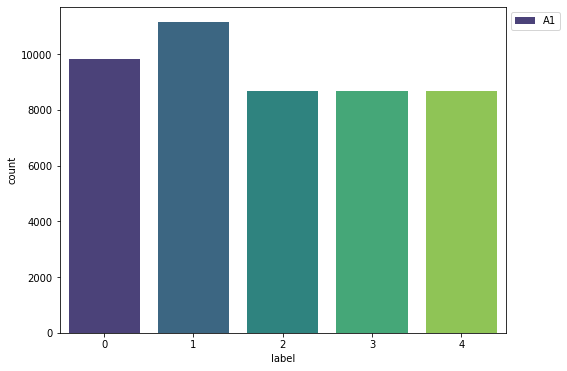

In [ ]:
# Gráfico de barras de registros por característica categorica tras upsampling minoritarias
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='label', data=df, orient='h', palette='viridis', order =[0, 1, 2, 3, 4])
plt.legend(labels = ['A1', 'A2', 'B1', 'B2', 'C1'], loc = 2, bbox_to_anchor = (1,1))

## 3.2.Upsamplig Clases Minoritarias + Downsampling Clases Mayoritarias (df_)

In [ ]:
# Volvemos a tomar el corpus_train_val inicial
df_ = corpus_train_val
# Igualamos al nivel de la clase B1=2 (10848) tanto en Upsampling como Downsampling
regSample = df_[df_.label==2].shape[0]

In [ ]:
# Fraccionar el dataset, aislando todas las clases
df_A1 = df_[df_.label==0]
df_A2 = df_[df_.label==1]
df_B1 = df_[df_.label==2]
df_B2 = df_[df_.label==3]
df_C1 = df_[df_.label==4]

In [ ]:
# Upsampling de la clase minoritaria  B2:
df_B2plus = resample(df_B2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Upsampling de la clase minoritaria  C1:
df_C1plus = resample(df_C1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Downsampling de la clase mayoritaria  A1:
df_A1plus = resample(df_A1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Downsampling de la clase mayoritaria  A2:
df_A2plus = resample(df_A2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Componemos de nuevo el dataset con las clases balanceadas a B1
# Son A1=0, A2=1, B2=3 y C1=4 

niveles = [0, 1, 3, 4]

print(df_.shape)
print(df_['label'].value_counts())

for nv in niveles:
  df_ = df_.drop(df_[df_['label']==nv].index)

df_ = pd.concat([df_A1plus, df_A2plus, df_, df_B2plus, df_C1plus])

print(df_.shape)
print(df_['label'].value_counts())

(37429, 2)
1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
(43390, 2)
0    8678
1    8678
2    8678
3    8678
4    8678
Name: label, dtype: int64


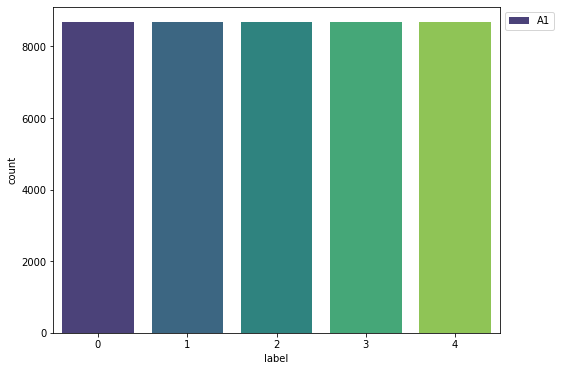

In [ ]:
# Gráfico de barras de registros por característica categorica tras upsampling minoritarias
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='label', data=df_, orient='h', palette='viridis', order =[0, 1, 2, 3, 4])
plt.legend(labels = ['A1', 'A2', 'B1', 'B2', 'C1'], loc = 2, bbox_to_anchor = (1,1))

# 4.Establecer Tipo de Balanceado de datos entrenamiento
Se han creado 3 datasets para poder realizar pruebas:
* **df0**: Dataset sin balancear
* **df**: Dataset casi balanceado (solo upsampling)
* **df_**: Dataset balanceado (upsamplig + downsampling)
Todos ellos son dataset de pruebas, en los que ahora debemos realizar la segmentación train/Validation

In [ ]:
# Para realizar las pruebas, tenemos que dar valor a corpus_train_val con uno de los dataset anteriores.
# Esta opción nos deja a corpus_test totalmente libre para poder realizar la verificación del modelo con datos reales
corpus_train_val=df0

# 5.Segmentación Train + Validation
Realizamos la segmentación del conjunto Train/Val, conservando las proporciones de estratificación existentes en el mismo (puede estar balanceado o no dependiendo del la elección en la sección anterior)
Separados los dos conjuntos, verificamos la correcta segmentación, añadimos una columna que nos permita diferenciarlos y volvemos a componer el conjunto unido (es requerimiento de la biblioteca FastAI)

In [ ]:
# Mantendremos en esta segmentación la estratificación del conjunto base (corpus_train_val)
# Nótese que es diferente dependiendo de el tipo de balanceado y que eso lo determinamos con y2
y2 = corpus_train_val['label'].values
corpus_train, corpus_valid = train_test_split(corpus_train_val, test_size=0.2, random_state=seed, shuffle=True, stratify = y2)

In [ ]:
# Información Conjunto Train
print(corpus_train['label'].value_counts())
print(corpus_train.shape[0])

1    8913
0    7861
2    6942
3    4225
4    2002
Name: label, dtype: int64
29943


In [ ]:
# Información Conjunto Valid
print(corpus_valid['label'].value_counts())
print(corpus_valid.shape[0])

1    2228
0    1966
2    1736
3    1056
4     500
Name: label, dtype: int64
7486


Juntamos ahora nuestro conjunto de entrenamiento y de validación. Para poder diferenciarlos vamos a añadir una columna a cada uno de ellos para indicar al conjunto al que pertenecen. La columna ``set`` va a tener dos valores: True si pertenece al conjunto de validación y False si pertenece al conjunto de test.

In [ ]:
corpus_train['set']=False
corpus_valid['set']=True

In [ ]:
# Juntamos los datasets Train + Validation
corpus_train_val = pd.concat([corpus_train, corpus_valid])
corpus_train_val

,text,label,set
16995,"No , está las palabras cheat_fair .",2,False
28814,Vivimos en un país donde se permite humar cigarrillos y aún se paga altas tasas de impuestos .,3,False
3908,"Por eso , quiero seguir un programa academico en españa para mejorar mis competencias técnicas , comerciales y de compresión de la lengua y cultura españolas en_vista_de encontrar a empresas españolas .",3,False
43512,Puedes hacer guia proximo mes ?,2,False
38237,"Para obtener a visa para estudiar , ¿ necesito obtener un otra visa para trabajar a el mismo tiempo ?",3,False
...,...,...,...
40424,"Buenas tardes , me llamo Bárbara_Cunha y escribo con la intención de reservar una habitacíon para la ultima semana de noviembre de el año 2012 .",1,True
46585,Un abrazo Pedro,0,True
12229,"Soy simpatica y amable . tengo el pelo liso y largo , tengo los ojos marrones .",0,True
9750,su enfadado cliente .,4,True


In [ ]:
# Información Conjunto Train/Val
print(corpus_train_val['label'].value_counts())
print(corpus_train_val.shape[0])
print(corpus_train_val.shape)

1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
37429
(37429, 3)


In [ ]:
# Obtener información sobre cualquier función de fastAI
# Para que se vea mejor hay que instalar previamente
# pip install nbdev
doc(ClassificationInterpretation.from_learner)

# 6.El modelo de clasificación

El proceso para entrenar un modelo es el mismo que hemos visto para los modelos de clasificación de imágenes y podemos usar toda la funcionalidad vista hasta ahora. Comenzamos definiendo un `DataBlock` que se creará a partir de nuestro dataframe `df`. Tendremos que definir también una función que nos indique cuándo un poema es del conjunto de entrenamiento o del de validación.   

## 6.1.Creación del DataBlock

In [ ]:
languageLevel_clas = DataBlock(
    blocks=(TextBlock.from_df('text'), CategoryBlock), # La entrada del modelo es texto, y la salida una clase 
    get_x=ColReader('text'),  # Indicamos donde estará el texto dentro del dataframe
    get_y=ColReader('label'), # Indicamos cómo extraer la clase del dataframe
    splitter=ColSplitter('set') # Partimos el dataset en entrenamiento y validación
)

## 6.2.Creación del Dataloader 

In [ ]:
dls = languageLevel_clas.dataloaders(corpus_train_val, bs=512)

Podemos mostrar un batch de nuestro dataloader. 

In [ ]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos xxup xxunk xxup ver xxup te , xxup porque xxup no xxup viene xxup aca xxup en xxup casa y xxup cena xxup con xxup nosotros xxup estamos xxup haciendo xxup xxunk xxup xxunk xxup una xxup xxunk xxup de xxup vino xxup para xxup comemorar xxup la xxup vuelta xxup de xxup mama xxup di xxup me xxup algo xxup estarei xxup aca xxup esperando xxup te …",0
1,"xxbos xxup xxunk , xxup hoy xxup no xxup llego xxup a_tiempo xxup para xxup cenar , xxup no xxup xxunk xxup esperar xxup me xxup lo xxup ciento xxup pero xxup es xxup que xxup hoy xxup es xxup xxunk xxup de xxup maria y xxup le xxup vamos a xxup hacer xxup una xxup xxunk xxup en xxup su xxup despacho ! ! !",0


In [ ]:
# Obtenermos un resumen de la configuración del DataBlock (no es necesario, solo informativo)
languageLevel_clas.summary(corpus_train_val)

## 6.3.Creación del modelo de clasificación

Pasamos ahora a crear nuestro `learner` usando el método `text_classifier_learner` al que pasamos como arquitectura de red la arquitectura [AWD_LSTM](https://arxiv.org/abs/1708.02182), además aplicamos dropout a nuestro modelo. 

### 6.3.1.Establecimiento de métricas

In [ ]:
# Definir instancias de objetos para diferentes métricas (predefinicas en fastai)

recall_score = Recall(average ='weighted')
precision_score = Precision(average ='weighted')
#f1_score = F1Score(average ='weighted')
metrics = [accuracy, precision_score, recall_score]

In [ ]:
#callbacks = [ShowGraphCallback(),                             # Mostrar grafica con las curvas de entrenamiento y validacion
#             SaveModelCallback(),                             # Guardar el mejor modelo encontrado durante entrenamiento y carga al final del mismo. Podemos Como vamos a crear un modelo usando la arquitectura resnet18 conviene que indiquemos esto en el nombre del modelo. También sería conveniente indicar el nombre del dataset para no confundirlos
#             EarlyStoppingCallback(patience=3),               # Parada anticipada si en 3 epoch no mejora la pérdida
#             ReduceLROnPlateau(patience = 1, min_lr = 1e-8)]

### 6.3.2.Establecimiento de Callbacks

In [ ]:
callbacks = [ShowGraphCallback(),                             # Mostrar grafica con las curvas de entrenamiento y validacion
             SaveModelCallback(),                             # Guardar el mejor modelo encontrado durante entrenamiento y carga al final del mismo. Podemos Como vamos a crear un modelo usando la arquitectura resnet18 conviene que indiquemos esto en el nombre del modelo. También sería conveniente indicar el nombre del dataset para no confundirlos
             EarlyStoppingCallback(patience=3),               # Parada anticipada si en 3 epoch no mejora la pérdida
             ReduceLROnPlateau(patience = 1, min_lr = 1e-8)]

### 6.3.3.Creación del modelo LSTM

In [ ]:
%%time
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=metrics,cbs=callbacks).to_fp16()

CPU times: user 529 ms, sys: 130 ms, total: 659 ms
Wall time: 692 ms


In [ ]:
# Veamos las caracteristicas del modelo
learn.summary()

## 6.4.Entrenamiento del modelo 

### 6.4.1.Determinación del Learning Rate

CPU times: user 4.64 s, sys: 541 ms, total: 5.18 s
Wall time: 47.7 s


SuggestedLRs(valley=0.0010000000474974513)

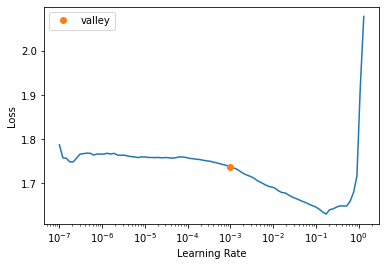

In [ ]:
%%time
learn.lr_find()

### 6.4.2.Ajuste fino del modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.639535,1.533683,0.347315,0.405189,0.347315,00:34


Better model found at epoch 0 with valid_loss value: 1.5336828231811523.


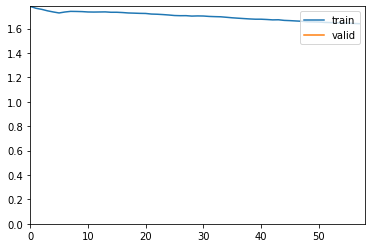

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.549252,1.517559,0.366284,0.428098,0.366284,00:36
1,1.527932,1.491345,0.380310,0.434338,0.380310,00:34
2,1.500324,1.430767,0.415442,0.433124,0.415442,00:34
3,1.465458,1.415149,0.417579,0.442334,0.417579,00:34
4,1.429672,1.371405,0.446166,0.457896,0.446166,00:34
5,1.394813,1.316109,0.465001,0.470707,0.465001,00:36
6,1.366541,1.287344,0.472616,0.474263,0.472616,00:34
7,1.333385,1.266151,0.475287,0.489984,0.475287,00:34
8,1.313504,1.234486,0.498931,0.507461,0.498931,00:35
9,1.290703,1.230085,0.499466,0.511906,0.499466,00:34


Better model found at epoch 0 with valid_loss value: 1.5175585746765137.


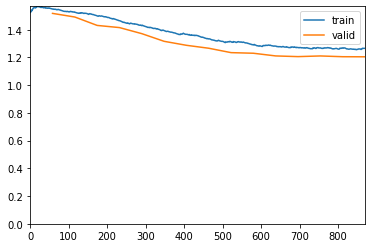

Better model found at epoch 1 with valid_loss value: 1.4913450479507446.
Better model found at epoch 2 with valid_loss value: 1.430767297744751.
Better model found at epoch 3 with valid_loss value: 1.415149211883545.
Better model found at epoch 4 with valid_loss value: 1.3714048862457275.
Better model found at epoch 5 with valid_loss value: 1.31610906124115.
Better model found at epoch 6 with valid_loss value: 1.2873443365097046.
Better model found at epoch 7 with valid_loss value: 1.2661510705947876.
Better model found at epoch 8 with valid_loss value: 1.23448646068573.
Better model found at epoch 9 with valid_loss value: 1.2300845384597778.
Better model found at epoch 10 with valid_loss value: 1.2107051610946655.
Better model found at epoch 11 with valid_loss value: 1.2057762145996094.
Epoch 12: reducing lr to 4.417409722292271e-06
Better model found at epoch 13 with valid_loss value: 1.2050508260726929.
Better model found at epoch 14 with valid_loss value: 1.2044752836227417.
CPU ti

In [ ]:
%%time
learn.fine_tune(nEpochs, 1.0e-3)

In [ ]:
# La validacion, sobre el conjunto de train, nos indica el mejor modelo
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5133582949638367.


(#4) [1.2044752836227417,0.5133582949638367,0.5205646432715426,0.5133582687683677]

### 6.4.3.Creación Matriz Confusión (Entrenamiento)

In [ ]:
# Obtener la matriz de confusión. Mediante un objeto "interp"
interp = ClassificationInterpretation.from_learner(learn)

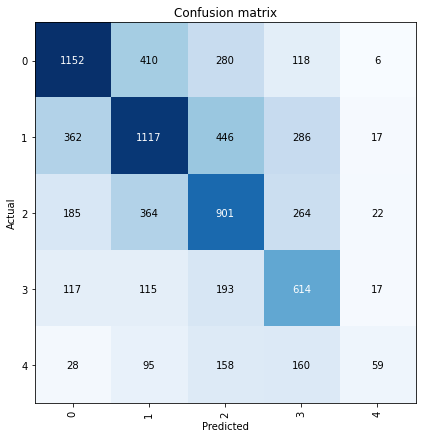

In [ ]:
# Matriz de Confusión sobre el conjunto de validación (corpus_train_val[set=True])
interp.plot_confusion_matrix(figsize =(10,6))

In [ ]:
# Muestra la estructura del modelo (no es necesario, solo informativo)
learn.summary()

### 6.4.4.Guardado del modelo

In [ ]:
# Establecer el directorio en el que se guarde el modelo y el nombre (siempre sin extensión)
path ='/content/drive/MyDrive/Modelos/'
model_name = path+'ModeloBS512-02012023-5133'
model_name

'/content/drive/MyDrive/Modelos/ModeloBS512-02012023-5133'

In [ ]:
# Guardado del modelo
learn.export(f'{model_name}.pkl')

In [ ]:
# Importación del modelo guardado en disco
nombre_modelo = path+'ModeloBS512-02012023-5133'
learn2 = load_learner(f'{nombre_modelo}.pkl')

In [ ]:
# Verificar que hemos recuperado el modelo y se comporta igual
# Para usarlo, tras cagar los pesos, hay que indicarle los datos sobre los que trabajar. Ahora los de Train por eso dls
learn2.dls = dls
learn.validate()


Better model found at epoch 0 with valid_loss value: 0.5133582949638367.


(#4) [1.2044752836227417,0.5133582949638367,0.5205646432715426,0.5133582687683677]

### 6.4.5.Predicción (Entrenamiento)


In [ ]:
# Es A1
learn.predict('Es un dia que nuca olvidere')

('2', tensor(2), tensor([0.1092, 0.2809, 0.2902, 0.1254, 0.1943]))

In [ ]:
# Es A2
learn.predict('Una persona que admiro es mi mejor amiga Chandler .')

('1', tensor(1), tensor([0.1685, 0.5986, 0.1857, 0.0161, 0.0312]))

In [ ]:
# Es B1
learn.predict('Las entradas dijo el nombre de el cine , nos equivocamos .')

('2', tensor(2), tensor([0.1095, 0.2427, 0.3807, 0.1294, 0.1377]))

In [ ]:
# Es B2
learn.predict('Vengo solicitar admisión en el programa de postgrado de lengua e literatura española de esta universidad .')

('3', tensor(3), tensor([0.0722, 0.0600, 0.0912, 0.7302, 0.0465]))

In [ ]:
# Es C1
learn.predict('Tuve un conversaciòn con su compañia durante el mes de septiembre y me dijeron que el precio por la electricidad serìa muy barato y por el telefono serìa solomente 20 E por cada mes .')

('2', tensor(2), tensor([0.0700, 0.1845, 0.4270, 0.1279, 0.1906]))

In [ ]:
# Frase aleatoria
learn.predict('Quizás no sea este el mejor de los momentos para tratar el asunto que me mencionas')

('3', tensor(3), tensor([0.0674, 0.0472, 0.2342, 0.4071, 0.2440]))

## 6.5.Validacion del modelo
En esta sección se lleva a cabo la validación de nuestro modelo sobre el conjunto de Test reservado para ello. Para ello:

* Análisis del cojunto de Test (corpus_test)
* Adición de la columna "set" a Test. Verificación
* Combinación de los cojuntos de Train y Test
* Crear un nuevo dataloader con Train+Test
* Validar el modelo de clasificación

### 6.5.1.Combinación de Train+Test para validar

In [ ]:
# Visualizamos el conjunto reservado para Test
corpus_test

,text,label,set
2065,"¿ Teneis , en su hotel , algun tipo de guia turistico ?",1,True
10734,Estoy creando una empresa y necesito a una persona que pueda ayudar me sobre mi sitio internet .,2,True
30395,"me llamo Sophie , soy francese y vivo en Lyon .",0,True
26515,"Ademas , los gente que fumo no le gusta respirar el aire en el que otros personas fuman .",3,True
41896,Estoy escribiendo un reportaje para una clase de el español y el tema es sobre,2,True
...,...,...,...
30876,En estas ultimas vacaciones me he divertido mucho y todavia no he hecho nada de muy especial .,1,True
34783,"También , ¿ Como es la estructura de el programa ?",3,True
12039,Espero ver les pronto .,0,True
3076,"Enctonces , cuando los leyes se impusieron contra fumar en lugares publicos , me lo agredecio .",3,True


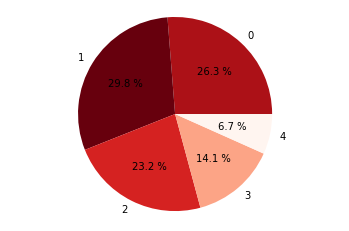

In [ ]:
# Mostramos segmentación de corpus_test
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

a = corpus_train["label"].value_counts()
n = [0, 1, 2, 3, 4]
cont = [a[i] for i in n]

normdata = colors.Normalize(min(cont), max(cont))
colormap = cm.get_cmap("Reds")
colores =colormap(normdata(cont))

plt.pie(cont, labels=n, autopct="%0.1f %%", colors=colores)
plt.axis("equal")
plt.show()

In [ ]:
# Le indicamos que se trata del conjunto de "validación", porque lo vamos a unir a Train
corpus_test['set']=True
corpus_test

,text,label,set
2065,"¿ Teneis , en su hotel , algun tipo de guia turistico ?",1,True
10734,Estoy creando una empresa y necesito a una persona que pueda ayudar me sobre mi sitio internet .,2,True
30395,"me llamo Sophie , soy francese y vivo en Lyon .",0,True
26515,"Ademas , los gente que fumo no le gusta respirar el aire en el que otros personas fuman .",3,True
41896,Estoy escribiendo un reportaje para una clase de el español y el tema es sobre,2,True
...,...,...,...
30876,En estas ultimas vacaciones me he divertido mucho y todavia no he hecho nada de muy especial .,1,True
34783,"También , ¿ Como es la estructura de el programa ?",3,True
12039,Espero ver les pronto .,0,True
3076,"Enctonces , cuando los leyes se impusieron contra fumar en lugares publicos , me lo agredecio .",3,True


In [ ]:
# Combinación de Train + Test
corpus_train_test = pd.concat([corpus_train,corpus_test])

### 6.5.2.Nuevo Dataloader con datos Test

In [ ]:
# Construcción de un nuevo dataloader
dls_test = languageLevel_clas.dataloaders(corpus_train_test, bs=512)

### 6.5.3.Validación

In [ ]:
# Modificación del dataloader en el modelo y validación
learn.dls = dls_test
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5016028881072998.


(#4) [1.2139825820922852,0.5016028881072998,0.5062210176338965,0.5016029066039752]

### 6.5.4.Creación Matriz de Confusión

In [ ]:
# Vamos a analizar el comportamiento del modelo sobre el conjunto de test
# Para ello creamos un nuevo objeto interp para el conjunto de test (nosotros el modelo de train y el de test lo sobreescribimos al cambiar el dls)
interp_test = ClassificationInterpretation.from_learner(learn)

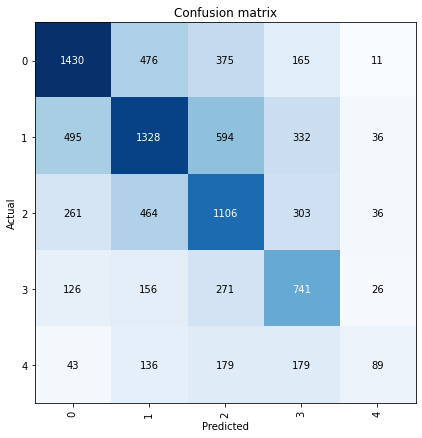

In [ ]:
# Matriz de Confusión sobre el conjunto de test (corpus_train_test[set=True])
interp_test.plot_confusion_matrix(figsize =(10,6))

### 6.5.5.Determinación errores del modelo

In [ ]:
# Errores de modelo de mayor a menor
interp_test.most_confused()

[(1, 2, 594),
 (1, 0, 495),
 (0, 1, 476),
 (2, 1, 464),
 (0, 2, 375),
 (1, 3, 332),
 (2, 3, 303),
 (3, 2, 271),
 (2, 0, 261),
 (4, 2, 179),
 (4, 3, 179),
 (0, 3, 165),
 (3, 1, 156),
 (4, 1, 136),
 (3, 0, 126),
 (4, 0, 43),
 (1, 4, 36),
 (2, 4, 36),
 (3, 4, 26),
 (0, 4, 11)]

In [ ]:
interp_test.plot_top_losses(30)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,input,target,predicted,probability,loss
0,"xxbos xxmaj por un lado , su cultura , sus costumbres , su historia me parecen fantásticas y por otro lado , me gustaría tener una experiencia nueva , lejos de xxmaj europa , que me xxunk conocer otro xxunk universitario .",3,2,0.6387963891029358,5.057386875152588
1,"xxbos xxmaj he ido a el xxunk desde xxmaj xxunk hasta xxmaj xxunk , y tengo el xxmaj xxunk xxmaj frances .",3,1,0.6220759749412537,5.020671844482422
2,"xxbos hola , me llamo xxunk , soy xxunk de tanger , soy profesor y tengo xxunk años .",1,0,0.6905191540718079,4.943037033081055
3,"xxbos xxmaj por_favor , llame me a el xxrep 3 5 - xxrep 4 5 o escriba me xxunk",1,2,0.91637122631073,4.79873514175415
4,"xxbos xxmaj yo soy xxunk , tiengo 19 anõs y soy de xxmaj curitiba , xxmaj brasil .",1,0,0.9129112362861633,4.79547643661499
5,"xxbos xxmaj mi padre se llama xxmaj hassan tiene 67 años , es un abogado .",1,0,0.9866668581962585,4.79547643661499
6,"xxbos xxmaj vivo en xxmaj atenas , xxmaj grecia , y tengo 65 años .",3,0,0.9227880239486694,4.571288108825684
7,"xxbos xxmaj me llamo xxunk , soy francés y tengo 19 años .",2,0,0.8923126459121704,4.512851715087891
8,xxbos xxmaj mi nombre es xxmaj xxunk y estoy en la secundaría .,3,0,0.8458859920501709,4.476524353027344
9,xxbos xxmaj mi padre me salvó y xxunk el pescado tambien .,2,0,0.8878126740455627,4.450959205627441
